# 1. Data Exploration

## Loading and visualizing our data

In [28]:
import kagglehub
import os

dataset_path = "/kaggle/input/realwaste/realwaste-main/RealWaste"
print(os.listdir(dataset_path))  # List all files/folders inside the dataset

['Metal', 'Glass', 'Paper', 'Vegetation', 'Cardboard', 'Textile Trash', 'Food Organics', 'Plastic', 'Miscellaneous Trash']


In [29]:
from random import sample
import pandas as pd

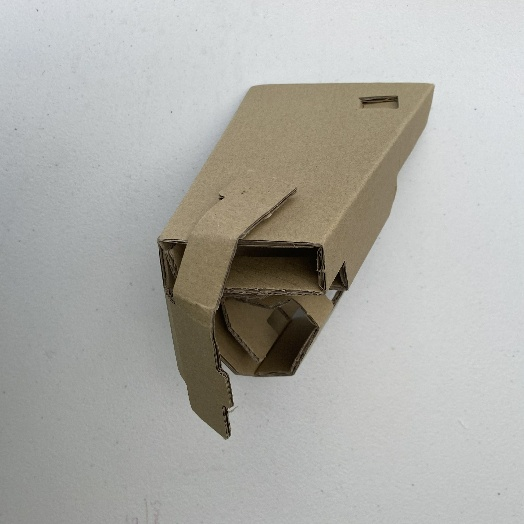

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img1 = load_img(f"{dataset_path}/Cardboard/Cardboard_10.jpg")
img1

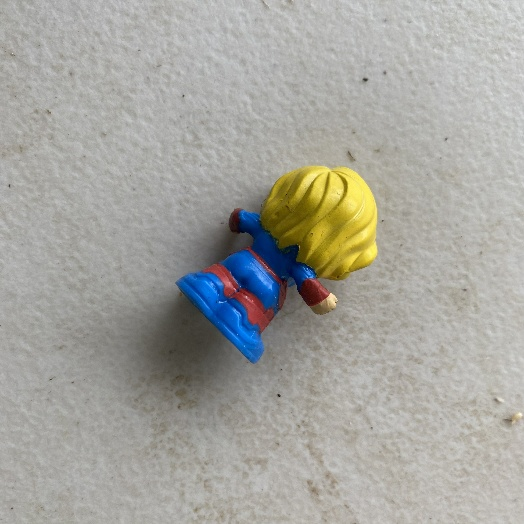

In [26]:
img2 = load_img(f"{dataset_path}/Miscellaneous Trash/Miscellaneous Trash_111.jpg")
img2

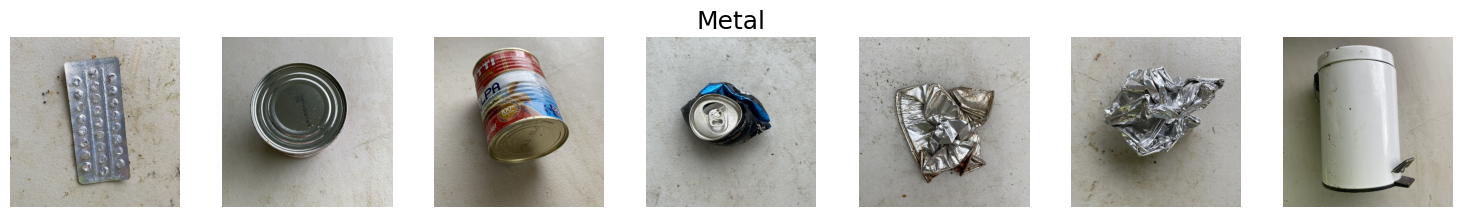

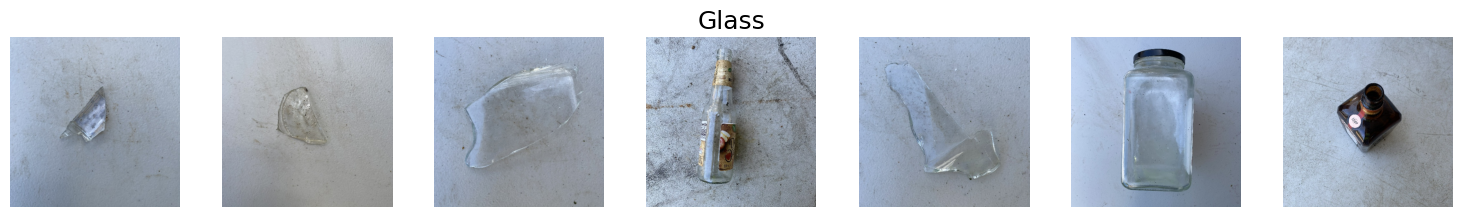

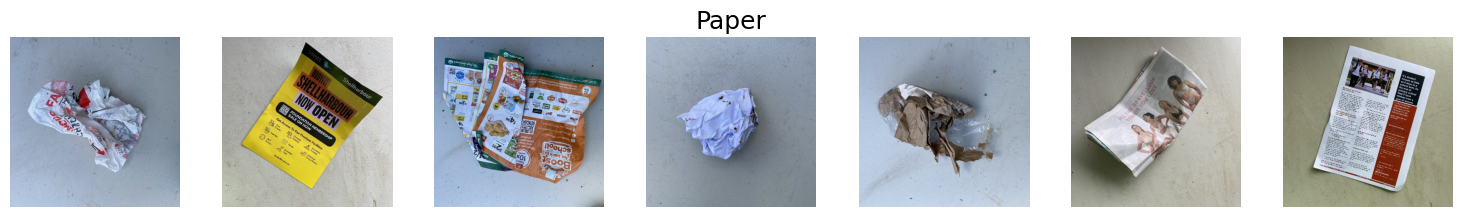

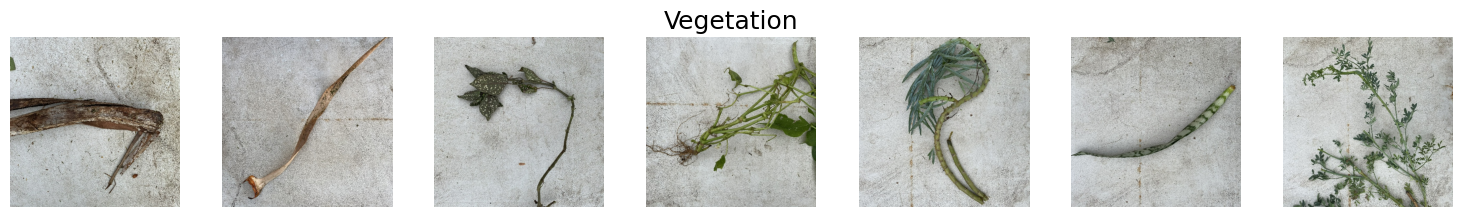

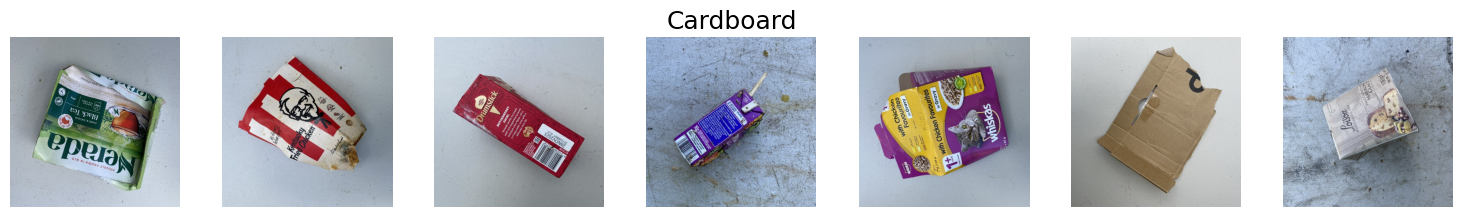

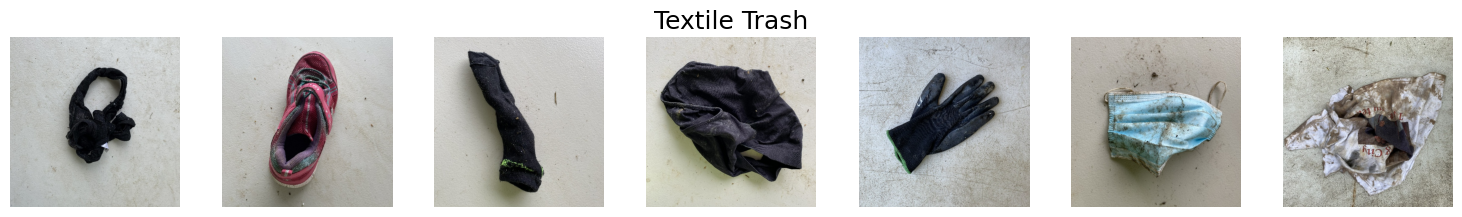

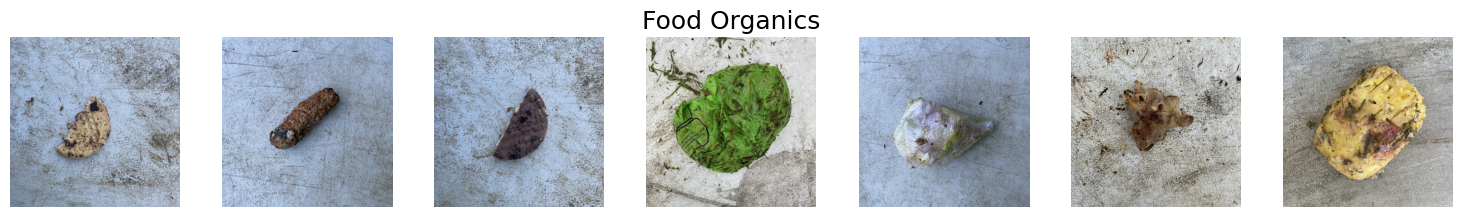

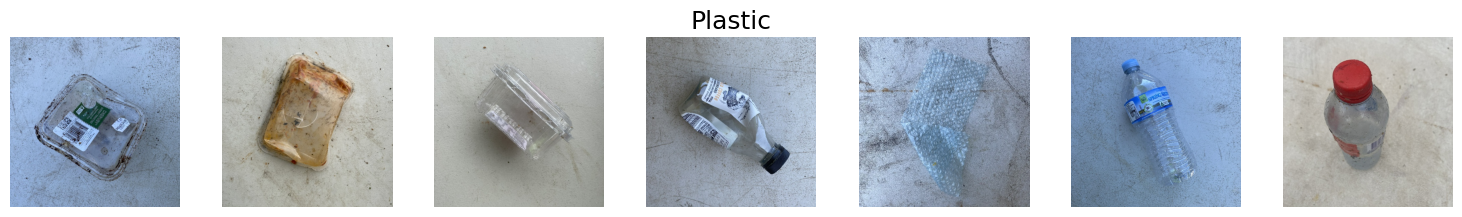

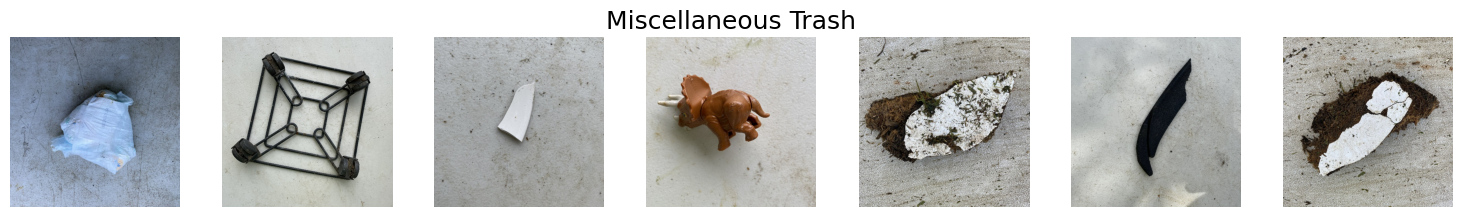

In [27]:
# Iterate over each trash type (folder) to display images
for waste_category in waste_categories:
    folder_path = os.path.join(dataset_path, waste_category)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Select 7 random images
        image_files = sample(image_files,7)

        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(waste_category, fontsize=18, y=1.06)
        plt.show()

## Checking image dimensions, properties and class distribution

In [5]:
import os
from PIL import Image

## Check Image Dimensions Before Splitting

# Define dataset path
dataset_path = "/kaggle/input/realwaste/realwaste-main/RealWaste"

# Retrieve the names of all folders (waste categories)
waste_categories = os.listdir(dataset_path)

# Set to store unique image dimensions
all_dimensions_set = set()

# Iterate over each category (folder) to process images
for category in waste_categories:
    folder_path = os.path.join(dataset_path, category)

    # Verify it's a valid directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]

        # Display the count of images in the current folder
        print(f"{category} folder contains {len(image_files)} images.")

        # Loop through each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))

# Print summary of image dimensions
if len(all_dimensions_set) == 1:
    width, height, channels = all_dimensions_set.pop()
    print(f"\n✅ All images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\n⚠️ The images in the dataset have different dimensions or color channels:")
    print(all_dimensions_set)

Metal folder contains 790 images.
Glass folder contains 420 images.
Paper folder contains 500 images.
Vegetation folder contains 436 images.
Cardboard folder contains 461 images.
Textile Trash folder contains 318 images.
Food Organics folder contains 411 images.
Plastic folder contains 921 images.
Miscellaneous Trash folder contains 495 images.

✅ All images in the dataset have the same dimensions: 524x524 with 3 color channels.


## Creating a dataframe to prepare for preprocessing 

In [31]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each waste type and collect its images' file paths
for waste_category in waste_categories:
    for file in os.listdir(os.path.join(dataset_path, waste_category)):
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, waste_category, file), waste_category))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.sample(20)

filepath                label
495   /kaggle/input/realwaste/realwaste-main/RealWas...                Metal
4010  /kaggle/input/realwaste/realwaste-main/RealWas...              Plastic
1999  /kaggle/input/realwaste/realwaste-main/RealWas...           Vegetation
1969  /kaggle/input/realwaste/realwaste-main/RealWas...           Vegetation
3075  /kaggle/input/realwaste/realwaste-main/RealWas...        Food Organics
861   /kaggle/input/realwaste/realwaste-main/RealWas...                Glass
1626  /kaggle/input/realwaste/realwaste-main/RealWas...                Paper
1967  /kaggle/input/realwaste/realwaste-main/RealWas...           Vegetation
1339  /kaggle/input/realwaste/realwaste-main/RealWas...                Paper
3478  /kaggle/input/realwaste/realwaste-main/RealWas...              Plastic
1226  /kaggle/input/realwaste/realwaste-main/RealWas...                Paper
4512  /kaggle/input/realwaste/realwaste-main/RealWas...  Miscellaneous Trash
2944  /kaggle/input/realwaste/realwaste-main/RealWas...        Food Organics
3435  /kaggle/input/realwaste/realwaste-main/RealWas...              Plastic
1956  /kaggle/input/realwaste/realwaste-main/RealWas...           Vegetation
103   /kaggle/input/realwaste/realwaste-main/RealWas...                Metal
2304  /kaggle/input/realwaste/realwaste-main/RealWas...            Cardboard
3818  /kaggle/input/realwaste/realwaste-main/RealWas...              Plastic
56    /kaggle/input/realwaste/realwaste-main/RealWas...                Metal
3919  /kaggle/input/realwaste/realwaste-main/RealWas...              Plastic

# 2. Data Preprocessing

In [34]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks

from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.model_selection import train_test_split

## Data Augmentation on Training Data

### Resizing, random flip, rotation, zoom, contrast & brightness, and translation

In [36]:
# Define augmentation layers (applied inside the model)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),            # Resize images
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip images randomly
    tf.keras.layers.RandomRotation(0.25),         # Rotate by 45 degrees (0.25 * 360)
    tf.keras.layers.RandomZoom(0.15),            # Zoom effect
    tf.keras.layers.RandomContrast(0.1),         # Adjust contrast
    tf.keras.layers.RandomTranslation(0.15, 0.15), # Shift images
    tf.keras.layers.RandomBrightness(0.1),       # Adjust brightness
])

# Apply augmentation **only to training set**
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Scale pixels to [0,1]
    image = data_augmentation(image)  # Apply augmentations
    return image, label

# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/RealWaste_split_data/train/",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
).map(preprocess_image)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/RealWaste_split_data/val/",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/RealWaste_split_data/test/",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

print("✅ TensorFlow Datasets Ready with Augmentation for Training and Rescaling for Validation/Test!")

Found 3323 files belonging to 9 classes.
Found 473 files belonging to 9 classes.
Found 956 files belonging to 9 classes.
✅ TensorFlow Datasets Ready with Augmentation for Training and Rescaling for Validation/Test!


# 3. Data Splitting for model training

In [20]:
!pip install split-folders

In [21]:
import splitfolders

# Define source dataset path
dataset_path = "/kaggle/input/realwaste/realwaste-main/RealWaste"

# Define destination (writable) directory in Kaggle
output_path = "/kaggle/working/RealWaste_split_data"

# Define split ratios
split_ratios = (0.7, 0.1, 0.2)  # Train: 70%, Val: 10%, Test: 20%

# Split the dataset
splitfolders.ratio(dataset_path, output=output_path, seed=1337, ratio=split_ratios)

print("✅ Dataset successfully split into Train (70%), Val (10%), and Test (20%) with stratification!")

Copying files: 4752 files [00:08, 533.07 files/s]

✅ Dataset successfully split into Train (70%), Val (10%), and Test (20%) with stratification!


## Training model using a CNN 

In [37]:
model = Sequential()

model.add(layers.Input((384, 384, 3)))
#model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )


model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )

model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )

model.add(layers.Flatten())

# Here we flatten our data to end up with just one dimension

model.add(layers.Dense(64, activation="relu"))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(6, activation="softmax"))

# And we perform the prediction using softmax

# 4. Model Training & Evaluation